In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.spatial.transform import Rotation
from scipy.signal import find_peaks, butter, filtfilt
from scipy.io import wavfile
from IPython.display import Audio
import ble_itf

ble_itf.mic_buf = []
ble_itf.imu_buf = {
	'ax': [],
	'ay': [],
	'az': [],
	'wx': [],
	'wy': [],
	'wz': [],
	'mx': [],
	'my': [],
	'mz': [],
}
await ble_itf.call()
print('imu data_rate: ', len(ble_itf.imu_buf['ax']) / 10)
print('mic data_rate: ', len(ble_itf.mic_buf) / 10)


Initializing...
Looking for devices...
Found  NANO_IMU  at address 78:5F:5A:74:2D:6F
Connecting...
Connected!
Disconnecting...
Disconnected!
imu data_rate:  440.0
mic data_rate:  2940.2


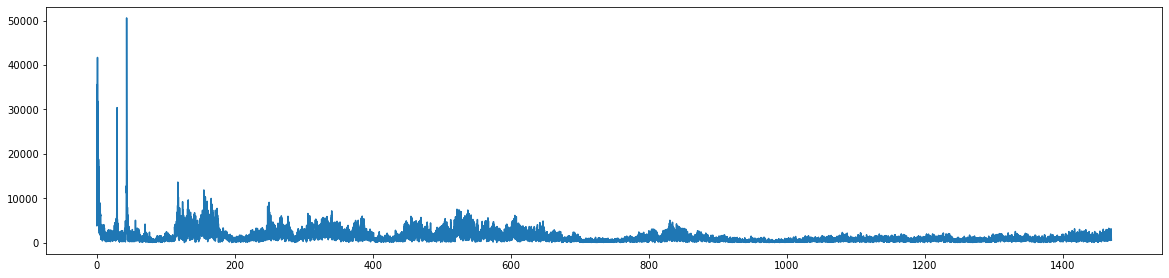

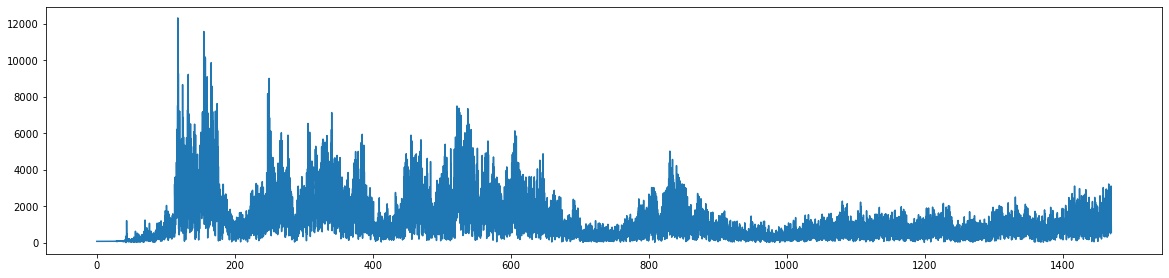

In [30]:
fs = len(ble_itf.mic_buf) / 10
b, a = butter(3, 80 / (fs/2), 'high')
y = filtfilt(b, a, ble_itf.mic_buf)

mic_fft = np.fft.rfft(ble_itf.mic_buf)
plt.figure(figsize = (20, 10))
plt.subplot(211)
plt.plot(np.linspace(0, fs/2, len(mic_fft)), np.abs(mic_fft))

y_fft = np.fft.rfft(y)
plt.figure(figsize = (20, 10))
plt.subplot(212)
plt.plot(np.linspace(0, fs/2, len(y_fft)), np.abs(y_fft))

In [13]:
ble_itf.imu_buf['mic'] = ble_itf.mic_buf
ble_itf.imu_buf['seconds'] = [10]
imu_df = pd.DataFrame.from_dict(ble_itf.imu_buf, orient='index')
imu_df = imu_df.transpose()
file_name = 'talking_pc_nonuser_2.csv'
imu_df.to_csv(file_name)
df = pd.read_csv(file_name)
# imu_buf = dict(df)
# imu_steps_per_sec(imu_buf)


In [ ]:
imu_steps_per_sec(imu_buf)

In [ ]:
def imu_steps_per_sec(imu_buf):

    steps = 0
    

    if len(imu_buf['ax']) >= 120 * 5:
        a_x = np.array(imu_buf['ax'])
        a_y = np.array(imu_buf['ay'])
        a_z = np.array(imu_buf['az'])
        a_xyz = a_x + a_y + a_z

        # low pass filter
        b, a = butter(3, 0.048, 'low')
        y = filtfilt(b, a, a_xyz)
        
        # take the fft
        y_fft = np.fft.rfft(y - min(y), n = 2048)
        y_fft[:10] = 0
        
        # plot the fft
        plt.figure(figsize = (20, 10))
        plt.subplot(211)
        plt.plot(range(len(y_fft)), np.abs(y_fft))
        plt.title('filtered imu fft')
        
        # plot the filtered signal
        plt.subplot(212)
        plt.plot(range(len(y)), y)
        plt.title('filtered imu data for steps')

        # peak detection
        y -= np.min(y)
        peaks = find_peaks(y, height = 0)
        steps = len(peaks[0])

    return steps


In [ ]:
ble_itf.mic_buf = []
ble_itf.imu_buf = {
	'ax' : [],
	'ay' : [],
	'az' : [],
	'wx' : [],
	'wy' : [],
	'wz' : [],
	'mx' : [],
	'my' : [],
	'mz' : [],
}

await ble_itf.call()
print('imu data_rate: ', len(ble_itf.imu_buf['ax']) / 10)
print('mic data_rate: ', len(ble_itf.mic_buf) / 10)

In [ ]:
def interp(arr, rate):
    ret = []
    for i in arr:
        ret.append(i)
        ret.extend([0 for i in range(rate - 1)])
    return ret

dual_channel = False
fs = 3000
# audio = np.fromfile("D:mic_data", dtype = np.int16)
audio = np.array(ble_itf.mic_buf)
# audio = interp(audio_orig, 32)
if dual_channel:
    audio = np.array([audio[::2], audio[1::2]])
print(len(audio))
Audio(data= 20 * audio, rate=fs)

In [ ]:
audio_fft = np.fft.rfft(audio)
audio_fft[:int(70/(len(audio)/10/2)*len(audio_fft))] = 0
plt.figure()
plt.plot(np.linspace(0, len(audio)/10/2, len(audio_fft)), np.abs(audio_fft))
print(np.linspace(0, len(audio)/10/2, len(audio_fft))[np.argmax(audio_fft)])

In [ ]:
plt.figure()
plt.plot(range(len(imu_data)), imu_data)

In [ ]:
imu_steps_per_sec(ble_itf.imu_buf)

In [ ]:
imu_dict = ble_itf.imu_buf
imu_fs = len(imu_dict['ax']) / 10
imu_data = np.array(imu_dict['ax']) + np.array(imu_dict['ay']) + np.array(imu_dict['az'])
imu_fft = np.fft.rfft(imu_data, n = 2**10)
imu_fft[:10] = 0
# imu_fft[:int(70/(imu_fs/2)*len(imu_fft))] = 0
# imu_fft[-int(70/(imu_fs/2)*len(imu_fft)):] = 0
imu_filtered = np.abs(np.fft.ifft(imu_fft))
plt.figure()
plt.plot(np.linspace(0, imu_fs / 2, len(imu_fft)), np.abs(imu_fft) ** 1)
print(np.linspace(0, imu_fs/2, len(imu_fft))[np.argmax(imu_fft)])

In [ ]:
plt.figure(figsize = (10, 10))
plt.subplot(211)
plt.specgram(audio, Fs = int(fs))[3]
plt.title('Microphone spectrogram')
plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')

plt.subplot(212)
plt.specgram(imu_filtered, Fs = int(imu_fs))[3]
plt.title('IMU spectrogram')
plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')

In [ ]:
plt.figure(figsize = (10, 10))
plt.subplot(211)
plt.specgram(audio, Fs = int(fs))[3]
plt.title('Microphone spectrogram')
plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')

plt.subplot(212)
plt.specgram(imu_filtered, Fs = int(imu_fs))[3]
plt.title('IMU spectrogram')
plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')

In [1]:
np.save('mic_talking_ed', ble_itf.mic_buf)

NameError: name 'np' is not defined